In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
from collections import OrderedDict
from PIL import Image, ImageDraw
from copy import deepcopy
import shutil
import random
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [50]:
dtypes = {"Image ID": object}
df_82 = pd.read_csv('./annotation_images/816_288_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
df_93 = pd.read_csv('./annotation_images/960_384_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)

In [51]:
df_82.head()

,Patient EID,File,Image ID,Ethnicity
0,5469894,1.2.840.113619.2.110.210419.20170405123025.1.1...,00001,Other
1,1877973,1.2.840.113619.2.110.210419.20180309092341.1.1...,00002,White
2,1312028,1.2.840.113619.2.110.210419.20180309094005.1.1...,00003,White
3,1426373,1.2.840.113619.2.110.210419.20180309102227.1.9...,00004,White
4,5853622,1.2.840.113619.2.110.210419.20180309105203.1.9...,00005,White


In [52]:
dict_82 = df_82[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()
dict_93 = df_93[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()

In [53]:
dict_93

{'1.2.840.113619.2.110.210419.20150904160201.2.12.12.1.jpg': '00001',
 '1.2.840.113619.2.110.210419.20150911150317.1.12.12.1.jpg': '00002',
 '1.2.840.113619.2.110.210419.20150911172121.1.12.12.1.jpg': '00003',
 '1.2.840.113619.2.110.210419.20150911181829.1.12.12.1.jpg': '00004',
 '1.2.840.113619.2.110.210419.20150911182115.1.12.12.1.jpg': '00005',
 '1.2.840.113619.2.110.210419.20150911182407.1.12.12.1.jpg': '00006',
 '1.2.840.113619.2.110.210419.20150911184915.1.12.12.1.jpg': '00007',
 '1.2.840.113619.2.110.210419.20150912100435.1.12.12.1.jpg': '00008',
 '1.2.840.113619.2.110.210419.20150912110752.1.12.12.1.jpg': '00009',
 '1.2.840.113619.2.110.210419.20150912111222.1.12.12.1.jpg': '00010',
 '1.2.840.113619.2.110.210419.20150912114418.1.12.12.1.jpg': '00011',
 '1.2.840.113619.2.110.210419.20150912122052.1.12.12.1.jpg': '00012',
 '1.2.840.113619.2.110.210419.20150912125024.1.12.12.1.jpg': '00013',
 '1.2.840.113619.2.110.210419.20150912133135.1.12.12.1.jpg': '00014',
 '1.2.840.113619.2.1

### Check if all annotated images are in the master list

In [54]:
for img_name in os.listdir('./annotation_images/816_288/'):
    if img_name not in dict_82.keys():
        print(img_name)

Patient_EID.csv
Patient_EID_v2.csv


In [55]:
for img_name in os.listdir('./annotation_images/960_384/'):
    if img_name not in dict_93.keys():
        print(img_name)

Patient_EID.csv
Patient_EID_v2.csv


##### So all of the images we annotated are in the master list

### Now we need to use `clean_annotations.py` to clean the annotationsd

#### Process 816x288

In [280]:
data = json.load(open("./annotation_images/816_288_17.json"))

In [281]:
file_list = os.listdir("./annotation_images/816_288/")
file_name2size = {}
for file_name in file_list:
    if file_name[-3:] == "jpg": #and file_name.startswith("1.2"):
        im = Image.open("./annotation_images/816_288/" + file_name)
        file_name2size[file_name] = list(im.size)
        im.close()

In [282]:
# OUTPUT1 = open("hip-3.json" + ".file_names.txt", "w")
OUTPUT1 = open("./annotation_images/id2file_names_82.txt", "w")
print("id", "old_file_name", "new_file_name", sep = "\t", file = OUTPUT1)

new_data = OrderedDict()

id2file_name = {}
new_data["images"] = []
for image in data["images"]:
    if image["file_name"] in file_name2size:
        id2file_name[image["id"]] = image["file_name"]
        temp_image = {}
        for element in image:
            if element in ['id', 'width', 'height', 'file_name']:
                temp_image[element] = image[element]
        # temp_image["file_name"] = "{:0>5}.jpg".format(int(temp_image["id"]))
        temp_image["file_name"] = dict_82[temp_image["file_name"]] + ".jpg"
        new_data["images"].append(temp_image)
        print(image["id"], image["file_name"], temp_image["file_name"], sep = "\t", file = OUTPUT1)
OUTPUT1.close()

In [283]:
new_data["categories"] = []
for category in data["categories"]:
    temp_category = {}
    for element in category:
        if element in ["name", "supercategory", "keypoints"]:
            temp_category[element] = category[element]
        if element == "id":
            temp_category[element] = 1
    new_data["categories"].append(temp_category)

In [284]:
new_data["annotations"] = []
for annot in data["annotations"]:
    if annot["image_id"] in id2file_name:
        file_name = id2file_name[annot["image_id"]]
        temp_annot = {}
        for element in annot:
            if element in ["id", "image_id", "category_id", "area", "bbox", "iscrowd", "isbbox", "keypoints", "num_keypoints"]:
                temp_annot[element] = annot[element]
        temp_annot["id"] = temp_annot["image_id"]
        temp_annot["category_id"] = 1
        temp_annot["iscrowd"] = 0
        temp_annot["isbbox"] = True
        temp_annot["bbox"] = [0, 0, file_name2size[file_name][0], file_name2size[file_name][1]]
        temp_annot["area"] = temp_annot["bbox"][2] * temp_annot["bbox"][3]
        new_data["annotations"].append(temp_annot)

In [285]:
with open("./annotation_images/816_288_17_filtered.json", "w") as OUTPUT:
    json.dump(new_data, OUTPUT, indent="  ")

#### Process 960x384

In [286]:
data = json.load(open("./annotation_images/960_384_17.json"))

In [287]:
file_list = os.listdir("./annotation_images/960_384/")
file_name2size = {}
for file_name in file_list:
    if file_name[-3:] == "jpg": #and file_name.startswith("1.2"):
        im = Image.open("./annotation_images/960_384/" + file_name)
        file_name2size[file_name] = list(im.size)
        im.close()

In [288]:
OUTPUT1 = open("./annotation_images/id2file_names_93.txt", "w")
print("id", "old_file_name", "new_file_name", sep = "\t", file = OUTPUT1)

new_data = OrderedDict()

id2file_name = {}
new_data["images"] = []
for image in data["images"]:
    if image["file_name"] in file_name2size:
        id2file_name[image["id"]] = image["file_name"]
        temp_image = {}
        for element in image:
            if element in ['id', 'width', 'height', 'file_name']:
                temp_image[element] = image[element]
        # temp_image["file_name"] = "{:0>5}.jpg".format(int(temp_image["id"]))
        temp_image["file_name"] = dict_93[temp_image["file_name"]] + ".jpg"
        new_data["images"].append(temp_image)
        print(image["id"], image["file_name"], temp_image["file_name"], sep = "\t", file = OUTPUT1)
OUTPUT1.close()

In [289]:
new_data["categories"] = []
for category in data["categories"]:
    temp_category = {}
    for element in category:
        if element in ["name", "supercategory", "keypoints"]:
            temp_category[element] = category[element]
        if element == "id":
            temp_category[element] = 1
    new_data["categories"].append(temp_category)

In [290]:
new_data["annotations"] = []
for annot in data["annotations"]:
    if annot["image_id"] in id2file_name:
        file_name = id2file_name[annot["image_id"]]
        temp_annot = {}
        for element in annot:
            if element in ["id", "image_id", "category_id", "area", "bbox", "iscrowd", "isbbox", "keypoints", "num_keypoints"]:
                temp_annot[element] = annot[element]
        temp_annot["id"] = temp_annot["image_id"]
        temp_annot["category_id"] = 1
        temp_annot["iscrowd"] = 0
        temp_annot["isbbox"] = True
        temp_annot["bbox"] = [0, 0, file_name2size[file_name][0], file_name2size[file_name][1]]
        temp_annot["area"] = temp_annot["bbox"][2] * temp_annot["bbox"][3]
        new_data["annotations"].append(temp_annot)

In [291]:
with open("./annotation_images/960_384_17_filtered.json", "w") as OUTPUT:
    json.dump(new_data, OUTPUT, indent="  ")

### Convert image name to new image name
-- e.g. 1.2.276.0.7230010.3.1.4.8323329.1000.1517875180.100.jpg -> 00001.jpg

In [268]:
# for 816x288

folder_path = './annotation_images/816_288_new/'

for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith('.jpg'):
        new_name = dict_82[filename] + '.jpg'
        os.rename(folder_path + filename, folder_path + new_name)

KeyError: '00132.jpg'

In [213]:
# for 960x384

folder_path = './annotation_images/960_384_new/'

for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith('.jpg'):
        new_name = dict_93[filename] + '.jpg'
        os.rename(folder_path + filename, folder_path + new_name)

KeyError: '09300.jpg'

### Now we need to use `draw_bounding_box.py` to draw bounding boxes on the images

In [269]:
img_names = []
img_ids = []
img_sizes = []

for filename in os.listdir("./annotation_images/816_288_new/"):    # parsing through every file in directory
    if filename[-3:] == 'jpg':  # if file is a JPEG
        img_names.append(filename)  # saving filename
        img_ids.append(int(filename[:-4]))  # saving file id (ie, 91 instead of '00091.jpg')
        im = Image.open("./annotation_images/816_288_new/" + filename)   # opening image
        img_sizes.append(list(im.size)) # saving image size as [width, height]
        im.close()  # closing image

outf = open('./annotation_images/bbox_816_288.json','w')  # creating output file
outf.write('[\n')   # writing the first line of the JSON

for i in range(len(img_names)-1):
    outf.write('  {\n    "bbox": [\n      0,\n      0,\n      '+str(img_sizes[i][0])+',\n      '+str(img_sizes[i][1])+'\n    ],\n'+
               '    "category_id": 1,\n    "image_id": '+str(img_ids[i])+',\n    "score": 1\n  },\n')
final_index = len(img_names)-1
outf.write('  {\n    "bbox": [\n      0,\n      0,\n      '+str(img_sizes[final_index][0])+',\n      '+str(img_sizes[final_index][1])+'\n    ],\n'+
               '    "category_id": 1,\n    "image_id": '+str(img_ids[final_index])+',\n    "score": 1\n  }\n]')
outf.close()

In [270]:
img_names = []
img_ids = []
img_sizes = []

for filename in os.listdir("./annotation_images/960_384_new/"):    # parsing through every file in directory
    if filename[-3:] == 'jpg':  # if file is a JPEG
        img_names.append(filename)  # saving filename
        img_ids.append(int(filename[:-4]))  # saving file id (ie, 91 instead of '00091.jpg')
        im = Image.open("./annotation_images/960_384_new/" + filename)   # opening image
        img_sizes.append(list(im.size)) # saving image size as [width, height]
        im.close()  # closing image

outf = open('./annotation_images/bbox_960_384.json','w')  # creating output file
outf.write('[\n')   # writing the first line of the JSON

for i in range(len(img_names)-1):
    outf.write('  {\n    "bbox": [\n      0,\n      0,\n      '+str(img_sizes[i][0])+',\n      '+str(img_sizes[i][1])+'\n    ],\n'+
               '    "category_id": 1,\n    "image_id": '+str(img_ids[i])+',\n    "score": 1\n  },\n')
final_index = len(img_names)-1
outf.write('  {\n    "bbox": [\n      0,\n      0,\n      '+str(img_sizes[final_index][0])+',\n      '+str(img_sizes[final_index][1])+'\n    ],\n'+
               '    "category_id": 1,\n    "image_id": '+str(img_ids[final_index])+',\n    "score": 1\n  }\n]')
outf.close()

### Randomly split the dataset into train and val

#### 816x288

In [292]:
data = json.load(open("./annotation_images/816_288_17_filtered.json"))

In [293]:
ids = [x['id'] for x in data['images']]
random.seed(42)
train_ids = random.sample(ids, 100)
val_ids = [x for x in ids if x not in train_ids]

In [294]:
train_data = {}
val_data = {}

train_images = []
train_annotations = []

val_images = []
val_annotations = []

for image in data['images']:
    if image['id'] in train_ids:
        train_images.append(image)
    else:
        val_images.append(image)

for annotation in data['annotations']:
    if annotation['image_id'] in train_ids:
        train_annotations.append(annotation)
    else:
        val_annotations.append(annotation)

train_data['images'] = train_images
train_data["categories"] = data["categories"]
train_data['annotations'] = train_annotations

val_data["images"] = val_images
val_data["categories"] = data["categories"]
val_data["annotations"] = val_annotations

In [295]:
with open("./annotation_images/train_816_288_17.json", "w") as OUTPUT:
    json.dump(train_data, OUTPUT, indent="  ")
with open("./annotation_images/val_816_288_17.json", "w") as OUTPUT:
    json.dump(val_data, OUTPUT, indent="  ")

#### 960x384

In [296]:
data = json.load(open("./annotation_images/960_384_17_filtered.json"))

In [297]:
ids = [x['id'] for x in data['images']]
random.seed(42)
train_ids = random.sample(ids, 100)
val_ids = [x for x in ids if x not in train_ids]

In [298]:
train_data = {}
val_data = {}

train_images = []
train_annotations = []

val_images = []
val_annotations = []

for image in data['images']:
    if image['id'] in train_ids:
        train_images.append(image)
    else:
        val_images.append(image)

for annotation in data['annotations']:
    if annotation['image_id'] in train_ids:
        train_annotations.append(annotation)
    else:
        val_annotations.append(annotation)

train_data['images'] = train_images
train_data["categories"] = data["categories"]
train_data['annotations'] = train_annotations

val_data["images"] = val_images
val_data["categories"] = data["categories"]
val_data["annotations"] = val_annotations

In [299]:
with open("./annotation_images/train_960_384_17.json", "w") as OUTPUT:
    json.dump(train_data, OUTPUT, indent="  ")
with open("./annotation_images/val_960_384_17.json", "w") as OUTPUT:
    json.dump(val_data, OUTPUT, indent="  ")

### Split the image dataset into train and val

#### 816x288

In [300]:
# get filenames for train and val

id2filename = pd.read_csv("./annotation_images/id2file_names_82.txt", sep="\t")
id2filename = id2filename[['id', 'new_file_name']].set_index("id")['new_file_name'].to_dict()

In [301]:
data = json.load(open("./annotation_images/train_816_288.json"))
train_ids = [x['id'] for x in data['images']]
data = json.load(open("./annotation_images/val_816_288.json"))
val_ids = [x['id'] for x in data['images']]

In [302]:
train_img_name = [id2filename[x] for x in train_ids]
val_img_name = [id2filename[x] for x in val_ids]

In [303]:
src_dir = "./annotation_images/816_288_new/"
train_dir = "./annotation_images/816_288_train/"
val_dir = "./annotation_images/816_288_val/"

for filename in train_img_name:
    shutil.copy(src_dir+filename, train_dir+filename)
for filename in val_img_name:
    shutil.copy(src_dir+filename, val_dir+filename)

#### 960x384

In [304]:
# get filenames for train and val

id2filename = pd.read_csv("./annotation_images/id2file_names_93.txt", sep="\t")
id2filename = id2filename[['id', 'new_file_name']].set_index("id")['new_file_name'].to_dict()

In [305]:
data = json.load(open("./annotation_images/train_960_384.json"))
train_ids = [x['id'] for x in data['images']]
data = json.load(open("./annotation_images/val_960_384.json"))
val_ids = [x['id'] for x in data['images']]

In [306]:
train_img_name = [id2filename[x] for x in train_ids]
val_img_name = [id2filename[x] for x in val_ids]

In [307]:
src_dir = "./annotation_images/960_384_new/"
train_dir = "./annotation_images/960_384_train/"
val_dir = "./annotation_images/960_384_val/"

for filename in train_img_name:
    shutil.copy(src_dir+filename, train_dir+filename)
for filename in val_img_name:
    shutil.copy(src_dir+filename, val_dir+filename)

### make id == filename

In [312]:
data = json.load(open("./annotation_images/train_816_288_17.json"))
id2filename = pd.read_csv("./annotation_images/id2file_names_82.txt", sep="\t")
id2filename = id2filename[['id', 'new_file_name']].set_index("id")['new_file_name'].to_dict()

In [313]:
for image in data['images']:
    image['id'] = int(image['file_name'].split(".")[0])
for image in data['annotations']:
    image['id'] = int(id2filename[image['image_id']].split(".")[0])
    image['image_id'] = int(id2filename[image['image_id']].split(".")[0])

In [314]:
with open("./annotation_images/train_816_288_17_idfilename.json", "w") as OUTPUT:
    json.dump(data, OUTPUT, indent="  ")

In [316]:
data = json.load(open("./annotation_images/train_960_384_17.json"))
id2filename = pd.read_csv("./annotation_images/id2file_names_93.txt", sep="\t")
id2filename = id2filename[['id', 'new_file_name']].set_index("id")['new_file_name'].to_dict()
for image in data['images']:
    image['id'] = int(image['file_name'].split(".")[0])
for image in data['annotations']:
    image['id'] = int(id2filename[image['image_id']].split(".")[0])
    image['image_id'] = int(id2filename[image['image_id']].split(".")[0])
with open("./annotation_images/train_960_384_17_idfilename.json", "w") as OUTPUT:
    json.dump(data, OUTPUT, indent="  ")

data = json.load(open("./annotation_images/val_960_384_17.json"))
for image in data['images']:
    image['id'] = int(image['file_name'].split(".")[0])
for image in data['annotations']:
    image['id'] = int(id2filename[image['image_id']].split(".")[0])
    image['image_id'] = int(id2filename[image['image_id']].split(".")[0])
with open("./annotation_images/val_960_384_17_idfilename.json", "w") as OUTPUT:
    json.dump(data, OUTPUT, indent="  ")

### combine train and val

In [317]:
train_data = json.load(open("./annotation_images/train_816_288_17_idfilename.json"))
val_data = json.load(open("./annotation_images/val_816_288_17_idfilename.json"))

In [318]:
# combine train and val
data = {}
data['images'] = train_data['images'] + val_data['images']
data['categories'] = train_data['categories']
data['annotations'] = train_data['annotations'] + val_data['annotations']

with open("./annotation_images/trainval_816_288_17.json", "w") as OUTPUT:
    json.dump(data, OUTPUT, indent="  ")

In [392]:
train_data = json.load(open("./annotation_images/train_960_384_17_idfilename.json"))
val_data = json.load(open("./annotation_images/val_960_384_17_idfilename.json"))

In [393]:
# combine train and val
data = {}
data['images'] = train_data['images'] + val_data['images']
data['categories'] = train_data['categories']
data['annotations'] = train_data['annotations'] + val_data['annotations']

with open("./annotation_images/trainval_960_384_17.json", "w") as OUTPUT:
    json.dump(data, OUTPUT, indent="  ")

### check keypoints number == 17

In [321]:
data = json.load(open("./annotation_images/trainval_816_288_17.json"))

for kp in data['annotations']:
    if kp['num_keypoints'] != 17:
        print(kp['num_keypoints'])

In [322]:
data = json.load(open("./annotation_images/trainval_960_384_17.json"))

for kp in data['annotations']:
    if kp['num_keypoints'] != 17:
        print(kp['num_keypoints'])

### make fake images annotation json data for testing

##### 816x288

In [399]:
image_ids = pd.read_csv("annotation_images/filename2id_82_testset.txt", sep = '\t')['new_file_name'].tolist()

data = json.load(open("annotation_images/train_816_288_17_idfilename.json"))

In [400]:
image_ids

['000001.jpg',
 '000002.jpg',
 '000003.jpg',
 '000004.jpg',
 '000005.jpg',
 '000006.jpg',
 '000007.jpg',
 '000008.jpg',
 '000009.jpg',
 '000010.jpg',
 '000011.jpg',
 '000012.jpg',
 '000013.jpg',
 '000014.jpg',
 '000015.jpg',
 '000016.jpg',
 '000017.jpg',
 '000018.jpg',
 '000019.jpg',
 '000020.jpg',
 '000021.jpg',
 '000022.jpg',
 '000023.jpg',
 '000024.jpg',
 '000025.jpg',
 '000026.jpg',
 '000027.jpg',
 '000028.jpg',
 '000029.jpg',
 '000030.jpg',
 '000031.jpg',
 '000032.jpg',
 '000033.jpg',
 '000034.jpg',
 '000035.jpg',
 '000036.jpg',
 '000037.jpg',
 '000038.jpg',
 '000039.jpg',
 '000040.jpg',
 '000041.jpg',
 '000042.jpg',
 '000043.jpg',
 '000044.jpg',
 '000045.jpg',
 '000046.jpg',
 '000047.jpg',
 '000048.jpg',
 '000049.jpg',
 '000050.jpg',
 '000051.jpg',
 '000052.jpg',
 '000053.jpg',
 '000054.jpg',
 '000055.jpg',
 '000056.jpg',
 '000057.jpg',
 '000058.jpg',
 '000059.jpg',
 '000060.jpg',
 '000061.jpg',
 '000062.jpg',
 '000063.jpg',
 '000064.jpg',
 '000065.jpg',
 '000066.jpg',
 '000067.j

In [401]:
test_data = {}
test_imgs = []
test_cate = []
test_anno = []

for img_id in image_ids:
    tmp_img = deepcopy(data['images'][0])
    tmp_img['id'] = int(img_id.split('.')[0]) + 100000
    tmp_img['file_name'] = str(int(img_id.split('.')[0]) + 100000) + '.jpg'
    # tmp_img['file_name'] = img_id
    test_imgs.append(tmp_img)

test_cate = deepcopy(data['categories'])

for img_id in image_ids:
    tmp_img = deepcopy(data['annotations'][0])
    tmp_img['id'] = int(img_id.split('.')[0]) + 100000
    tmp_img['image_id'] = int(img_id.split('.')[0]) + 100000
    test_anno.append(tmp_img)

test_data = {"images": test_imgs, "categories": test_cate, "annotations": test_anno}

In [402]:
with open("./annotation_images/test_82.json", "w") as OUTPUT:
    json.dump(test_data, OUTPUT, indent="  ")

##### 960x384

In [389]:
image_ids = pd.read_csv("annotation_images/filename2id_93_testset.txt", sep = '\t')['new_file_name'].tolist()

data = json.load(open("annotation_images/train_960_384_17_idfilename.json"))

In [390]:
test_data = {}
test_imgs = []
test_cate = []
test_anno = []

for img_id in image_ids:
    tmp_img = deepcopy(data['images'][0])
    tmp_img['id'] = int(img_id.split('.')[0]) + 100000
    tmp_img['file_name'] = str(int(img_id.split('.')[0]) + 100000) + '.jpg'
    test_imgs.append(tmp_img)

test_cate = deepcopy(data['categories'])

for img_id in image_ids:
    tmp_img = deepcopy(data['annotations'][0])
    tmp_img['id'] = int(img_id.split('.')[0]) + 100000
    tmp_img['image_id'] = int(img_id.split('.')[0]) + 100000
    test_anno.append(tmp_img)

test_data = {"images": test_imgs, "categories": test_cate, "annotations": test_anno}

In [391]:
with open("./annotation_images/test_93.json", "w") as OUTPUT:
    json.dump(test_data, OUTPUT, indent="  ")

### make fake bounding box json data

##### 816x288

In [378]:
image_ids = pd.read_csv("annotation_images/filename2id_82_testset.txt", sep = '\t')['new_file_name'].tolist()
data = json.load(open("annotation_images/bbox_816_288.json"))

In [379]:
new_data = []
for id in image_ids:
    tmp_img = deepcopy(data[0])
    tmp_img['image_id'] = int(id.split(".")[0]) + 100000
    new_data.append(tmp_img)

In [381]:
with open("./annotation_images/test_bbox_82.json", "w") as OUTPUT:
    json.dump(new_data, OUTPUT, indent="  ")

##### 960x384

In [382]:
image_ids = pd.read_csv("annotation_images/filename2id_93_testset.txt", sep = '\t')['new_file_name'].tolist()
data = json.load(open("annotation_images/bbox_960_384.json"))

In [383]:
new_data = []
for id in image_ids:
    tmp_img = deepcopy(data[0])
    tmp_img['image_id'] = int(id.split(".")[0]) + 100000
    new_data.append(tmp_img)

In [385]:
with open("./annotation_images/test_bbox_93.json", "w") as OUTPUT:
    json.dump(new_data, OUTPUT, indent="  ")

### Varify the accuracy of the annotation

In [2]:
annotation_82_1 = json.load(open("annotation_images/tv_82_23kps.json"))
annotation_82_2 = json.load(open("annotation_images/test_82_230816.json"))
annotation_93_1 = json.load(open("annotation_images/tv_93_23kps.json"))
annotation_93_2 = json.load(open("annotation_images/test_93_230816.json"))

In [3]:
annotation_82_1_dict = {}

for img in annotation_82_1['images']:
    annotation_82_1_dict[img['id']] = {}
    annotation_82_1_dict[img['id']]['file_name'] = img['file_name']
    for kps in annotation_82_1['annotations']:
        if kps['image_id'] == img['id']:
            annotation_82_1_dict[img['id']]['keypoints'] = np.array(kps['keypoints']).reshape(-1, 3)[:, :-1]

In [4]:
annotation_82_2_dict = {}

for img in annotation_82_2['images']:
    annotation_82_2_dict[img['id']] = {}
    annotation_82_2_dict[img['id']]['file_name'] = img['file_name']
    for kps in annotation_82_2['annotations']:
        if kps['image_id'] == img['id']:
            annotation_82_2_dict[img['id']]['keypoints'] = np.array(kps['keypoints']).reshape(-1, 3)[:, :-1]

In [5]:
annotation_93_1_dict = {}

for img in annotation_93_1['images']:
    annotation_93_1_dict[img['id']] = {}
    annotation_93_1_dict[img['id']]['file_name'] = img['file_name']
    for kps in annotation_93_1['annotations']:
        if kps['image_id'] == img['id']:
            annotation_93_1_dict[img['id']]['keypoints'] = np.array(kps['keypoints']).reshape(-1, 3)[:, :-1]

In [6]:
annotation_93_2_dict = {}

for img in annotation_93_2['images']:
    annotation_93_2_dict[img['id']] = {}
    annotation_93_2_dict[img['id']]['file_name'] = img['file_name']
    for kps in annotation_93_2['annotations']:
        if kps['image_id'] == img['id']:
            annotation_93_2_dict[img['id']]['keypoints'] = np.array(kps['keypoints']).reshape(-1, 3)[:, :-1]

In [7]:
def cal_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [8]:
annotation_82_2_dict

{494: {'file_name': '1.2.840.113619.2.110.210419.20180319173427.1.12.12.1.jpg',
  'keypoints': array([[104, 334],
         [169, 332],
         [ 81, 352],
         [194, 350],
         [ 91, 389],
         [182, 388],
         [117, 429],
         [157, 428],
         [137, 418],
         [109, 380],
         [163, 380],
         [135, 359],
         [137, 406],
         [ 77, 401],
         [196, 399],
         [116, 420],
         [156, 418],
         [116, 372],
         [154, 371],
         [ 95, 378],
         [180, 377],
         [100, 411],
         [171, 405]])},
 495: {'file_name': '1.2.840.113619.2.110.210419.20180322141043.1.12.12.1.jpg',
  'keypoints': array([[118, 321],
         [186, 322],
         [ 94, 341],
         [209, 341],
         [111, 372],
         [192, 375],
         [135, 404],
         [171, 406],
         [151, 397],
         [126, 364],
         [177, 364],
         [151, 338],
         [152, 387],
         [100, 376],
         [201, 380],
         [135

In [9]:
hip_regions = ['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 
               'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 
               'pubic_tubercle', 'trochanter_left', 'trochanter_right', 'obturator_left', 'obturator_right', 
               'sacrum_left', 'sacrum_right', 'inferior_iliac_spine_left', 'inferior_iliac_spine_right','acetabular_inferior_left', 'acetabular_inferior_right']
img_names = []
for img in annotation_82_2_dict:
    img_names.append(annotation_82_2_dict[img]['file_name'])

df_82 = pd.DataFrame(columns = hip_regions, index = img_names)


for img in annotation_82_2_dict:
    img_name = annotation_82_2_dict[img]['file_name']
    kps1 = annotation_82_2_dict[img]['keypoints']
    for img2 in annotation_82_1_dict:
        if annotation_82_1_dict[img2]['file_name'] == img_name:
            kps2 = annotation_82_1_dict[img2]['keypoints']
    for i in range(len(hip_regions)):
        df_82.loc[img_name, hip_regions[i]] = cal_euclidean_distance(kps1[i][0], kps1[i][1], kps2[i][0], kps2[i][1])

In [10]:
df_82.shape

(10, 23)

In [11]:
df_82

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,...,trochanter_left,trochanter_right,obturator_left,obturator_right,sacrum_left,sacrum_right,inferior_iliac_spine_left,inferior_iliac_spine_right,acetabular_inferior_left,acetabular_inferior_right
1.2.840.113619.2.110.210419.20180319173427.1.12.12.1.jpg,1.0,3.162278,1.0,2.0,2.0,2.236068,5.09902,1.0,0.0,2.236068,...,1.414214,2.236068,1.0,2.236068,1.0,2.0,1.0,2.0,2.0,2.236068
1.2.840.113619.2.110.210419.20180322141043.1.12.12.1.jpg,1.0,1.0,1.0,1.0,2.236068,2.236068,3.0,1.0,1.0,3.0,...,1.0,1.414214,1.0,1.414214,0.0,1.0,1.0,1.414214,3.0,4.0
1.2.840.113619.2.110.210419.20180323183139.1.12.12.1.jpg,4.0,6.0,2.0,0.0,1.0,1.0,2.0,1.414214,1.414214,4.0,...,1.414214,1.414214,1.0,0.0,0.0,5.385165,1.0,1.0,1.414214,1.0
1.2.840.113619.2.110.210419.20180327185012.1.12.12.1.jpg,0.0,2.236068,0.0,0.0,0.0,0.0,0.0,0.0,1.414214,1.0,...,1.414214,1.0,0.0,0.0,2.828427,2.0,1.0,0.0,1.414214,2.0
1.2.840.113619.2.110.210419.20180412085031.1.12.12.1.jpg,1.414214,2.0,0.0,2.0,1.0,2.828427,1.414214,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,1.414214,1.0,2.828427,0.0,1.0
1.2.840.113619.2.110.210419.20180423150508.1.12.12.1.jpg,2.0,3.162278,1.0,1.0,1.0,2.236068,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,2.236068,1.0,7.28011,7.071068,0.0,0.0
1.2.840.113619.2.110.210419.20180426194009.1.12.12.1.jpg,1.0,3.0,1.414214,1.0,1.0,0.0,2.0,1.0,1.0,1.0,...,2.828427,1.0,0.0,0.0,1.0,2.0,1.414214,2.0,0.0,2.0
1.2.840.113619.2.110.210419.20180505093954.1.12.12.1.jpg,1.0,3.0,0.0,1.414214,1.414214,1.0,2.0,4.0,1.0,1.414214,...,0.0,0.0,1.0,1.0,3.0,1.414214,1.0,0.0,1.414214,1.0
1.2.840.113619.2.110.210419.20180507154607.1.12.12.1.jpg,1.414214,5.0,1.0,1.414214,1.0,1.0,1.414214,1.414214,1.0,0.0,...,1.414214,1.0,1.414214,0.0,2.236068,2.0,2.236068,1.414214,2.828427,1.0
1.2.840.113619.2.110.210419.20180511105945.1.12.12.1.jpg,1.0,1.414214,0.0,1.0,1.414214,1.0,0.0,4.0,1.0,1.0,...,1.0,2.236068,1.0,0.0,2.828427,4.242641,0.0,1.414214,1.0,3.0


In [12]:
img_names = []
for img in annotation_93_2_dict:
    img_names.append(annotation_93_2_dict[img]['file_name'])

df_93 = pd.DataFrame(columns = hip_regions, index = img_names)


for img in annotation_93_2_dict:
    img_name = annotation_93_2_dict[img]['file_name']
    kps1 = annotation_93_2_dict[img]['keypoints']
    for img2 in annotation_93_1_dict:
        if annotation_93_1_dict[img2]['file_name'] == img_name:
            kps2 = annotation_93_1_dict[img2]['keypoints']
    for i in range(len(hip_regions)):
        df_93.loc[img_name, hip_regions[i]] = cal_euclidean_distance(kps1[i][0], kps1[i][1], kps2[i][0], kps2[i][1])


In [13]:
df_93

,iliac_crest_left,iliac_crest_right,iliac_spine_left,iliac_spine_right,iliopubic_eminence_left,iliopubic_eminence_right,inferior_pubic_ramus_left,inferior_pubic_ramus_right,pubic_arch,sciatic_notch_left,...,trochanter_left,trochanter_right,obturator_left,obturator_right,sacrum_left,sacrum_right,inferior_iliac_spine_left,inferior_iliac_spine_right,acetabular_inferior_left,acetabular_inferior_right
1.2.840.113619.2.110.210419.20150913100316.2.12.12.1.jpg,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.414214,...,1.0,1.0,1.414214,1.0,2.236068,1.0,3.0,1.0,0.0,1.0
1.2.840.113619.2.110.210419.20150913101050.2.12.12.1.jpg,0.0,1.0,0.0,1.0,3.162278,2.236068,5.0,2.0,1.0,1.0,...,1.0,0.0,1.0,1.0,2.828427,1.414214,1.0,1.414214,2.236068,2.0
1.2.840.113619.2.110.210419.20150914105227.1.12.12.1.jpg,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,1.414214,1.0,...,2.0,1.0,0.0,1.0,1.0,1.414214,1.0,1.414214,2.236068,1.0
1.2.840.113619.2.110.210419.20150915095947.2.12.12.1.jpg,4.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,2.236068,2.0,1.0,1.414214,0.0,1.414214
1.2.840.113619.2.110.210419.20150915165625.2.12.12.1.jpg,2.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.414214,...,1.0,1.414214,1.0,0.0,0.0,2.236068,0.0,0.0,1.0,1.414214
1.2.840.113619.2.110.210419.20150916084111.2.12.12.1.jpg,1.0,2.0,1.0,2.0,1.0,1.414214,1.0,0.0,0.0,0.0,...,1.414214,2.0,1.414214,0.0,0.0,3.162278,0.0,0.0,3.0,3.162278
1.2.840.113619.2.110.210419.20150918095151.2.12.12.1.jpg,3.162278,3.0,1.0,0.0,0.0,1.0,3.0,2.236068,1.414214,1.0,...,1.414214,1.0,1.0,3.0,1.414214,2.0,2.236068,1.0,3.0,1.0
1.2.840.113619.2.110.210419.20150918104611.2.12.12.1.jpg,1.0,0.0,1.414214,1.0,2.0,1.0,1.0,4.0,1.0,1.0,...,2.236068,1.0,0.0,1.0,2.236068,0.0,3.605551,0.0,1.0,1.0
1.2.840.113619.2.110.210419.20150918110725.2.12.12.1.jpg,0.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,1.0,...,2.0,2.0,3.162278,1.0,1.0,3.162278,1.414214,1.0,1.414214,2.236068
1.2.840.113619.2.110.210419.20150918160129.1.12.12.1.jpg,0.0,1.0,1.0,1.0,1.0,1.414214,1.0,1.414214,1.0,0.0,...,1.414214,1.414214,1.0,1.0,2.236068,1.414214,1.0,1.0,0.0,0.0


In [24]:
df = pd.concat([df_82, df_93])

df = df[['iliac_crest_left', 'iliac_crest_right', 'iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right',
         'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum',
         'pubic_tubercle', 'inferior_iliac_spine_left', 'inferior_iliac_spine_right', 'acetabular_inferior_left', 'acetabular_inferior_right']]

df.rename(columns = {
    'iliac_crest_left': 'Iliac crest posterior right', 
    'iliac_crest_right': 'Iliac crest posterior left', 
    'iliac_spine_left': 'Iliac crest anterolateral right',
    'iliac_spine_right': 'Iliac crest anterolateral left',
    'iliopubic_eminence_left': 'Acetabulum posterosuperior right',
    'iliopubic_eminence_right': 'Acetabulum posterosuperior left', 
    'inferior_pubic_ramus_left': 'Ischiopubic ramus inferior right',
    'inferior_pubic_ramus_right': 'Ischiopubic ramus inferior left', 
    'pubic_arch': 'Pubic symphysis inferior', 
    'sciatic_notch_left': 'Pelvic inlet right',
    'sciatic_notch_right': 'Pelvic inlet left', 
    'sacrum': 'Sacrum midline', 
    'pubic_tubercle': 'Pubic symphysis superior', 
    'inferior_iliac_spine_left': 'Iliac body lateral right',
    'inferior_iliac_spine_right': 'Iliac body lateral left', 
    'acetabular_inferior_left': 'Acetabulum anteroinferior right',
    'acetabular_inferior_right': 'Acetabulum anteroinferior left'
}, inplace = True)
df.to_csv("./key_results/annotation_error.csv", index = True)


df_long = pd.melt(df, var_name='Variable', value_name='Value')

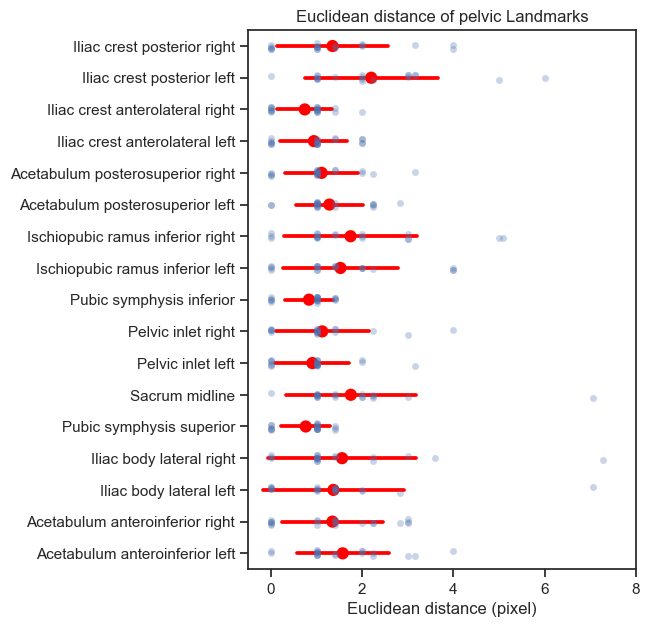

In [27]:
# selected_landmarks = ['iliac_spine_left', 'iliac_spine_right', 'iliopubic_eminence_left', 'iliopubic_eminence_right', 
#                         'inferior_pubic_ramus_left', 'inferior_pubic_ramus_right', 'pubic_arch', 'sciatic_notch_left', 'sciatic_notch_right', 'sacrum', 
#                         'trochanter_left', 'trochanter_right', 
#                         'sacrum_left', 'sacrum_right', 'inferior_iliac_spine_left', 'inferior_iliac_spine_right','acetabular_inferior_left', 'acetabular_inferior_right']
# df_landmarks = df_long[df_long['Variable'].isin(selected_landmarks)]

fig, ax = plt.subplots(figsize = (5, 7))
sns.set_theme(style="ticks", color_codes=True)
sns.stripplot(x="Value", y="Variable", data=df_long, alpha = 0.3, ax = ax)
sns.pointplot(
    data=df_long, x="Value", y="Variable",
    errorbar="sd", join=False, color="red",
    ax = ax
)

plt.xlabel("Euclidean distance (pixel)")
plt.ylabel("")
plt.xlim(-0.5, 8)
plt.title("Euclidean distance of pelvic Landmarks")
plt.savefig("out_fig/annotation_replicate.pdf", bbox_inches='tight')

## 2022-04-19 total 23 keypoints

In [5]:
img_path = "images/all_images_cp"
anno_path = "annotation_images/"
full_img_path = "../UKB_xray_image_info/jpg/816_288/"

### Load mapping files

In [6]:
dtypes = {"Image ID": object}
df_82 = pd.read_csv(anno_path + '816_288_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
df_93 = pd.read_csv(anno_path + '960_384_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
dict_82 = df_82[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()
dict_93 = df_93[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()

### Load annotations

In [7]:
anno_82 = json.load(open(os.path.join(anno_path, "tv_82_23kps.json")))
anno_93 = json.load(open(os.path.join(anno_path, "tv_93_23kps.json")))

### coco-annotations results convert to keypoints

#### For hip

In [8]:
anno_23kps = {}

for img in anno_82['images']:
    img_id = img['id']
    file_name = img['file_name']
    image_id = dict_82[file_name]
    for i in anno_82['annotations']:
        if i['image_id'] == img_id:
            kps = np.array(i['keypoints']).reshape(-1, 3)[:, :2]
            # according to central crop, adjust x,y
            kps[:, 0] = kps[:, 0] - 16
            kps[:, 1] = kps[:, 1] - 230
            kps = kps.tolist()
    anno_23kps[image_id  + '_82'] = kps

for img in anno_93['images']:
    img_id = img['id']
    file_name = img['file_name']
    image_id = dict_93[file_name]
    for i in anno_93['annotations']:
        if i['image_id'] == img_id:
            kps = np.array(i['keypoints']).reshape(-1, 3)[:, :2]
            # according to central crop, adjust x,y
            kps[:, 0] = kps[:, 0] - 64
            kps[:, 1] = kps[:, 1] - 302
            kps = kps.tolist()
    anno_23kps[image_id  + '_93'] = kps

In [9]:
len(anno_23kps.keys())

293

In [10]:
def show_kps(image_id):
    img_path = "images/all_images_cp"
    img = Image.open(os.path.join(img_path, image_id + ".jpg"))
    img = img.convert('RGB')
    draw = ImageDraw.Draw(img)
    # find corresponding kps
    kps = anno_23kps[image_id]
    for kp in kps:
        draw.ellipse((kp[0]-2, kp[1]-2, kp[0]+2, kp[1]+2), fill = 'red')
    return img

In [14]:
anno_23kps.keys()

dict_keys(['00093_82', '00132_82', '00157_82', '00223_82', '00398_82', '00579_82', '00631_82', '00755_82', '00793_82', '00847_82', '00860_82', '01061_82', '01325_82', '01460_82', '01560_82', '01588_82', '01643_82', '01684_82', '01751_82', '01900_82', '01910_82', '02049_82', '02170_82', '02191_82', '02192_82', '02257_82', '02358_82', '02406_82', '02533_82', '02541_82', '02754_82', '02957_82', '03108_82', '03128_82', '03162_82', '03460_82', '03736_82', '04183_82', '04255_82', '04401_82', '04777_82', '05022_82', '05065_82', '05074_82', '05273_82', '05435_82', '05445_82', '05572_82', '05646_82', '05658_82', '05678_82', '05687_82', '05747_82', '05862_82', '05980_82', '05998_82', '06295_82', '06474_82', '06731_82', '06742_82', '06755_82', '06914_82', '07281_82', '07398_82', '07769_82', '07887_82', '08217_82', '08516_82', '08582_82', '08768_82', '09322_82', '09349_82', '09689_82', '09799_82', '09869_82', '09948_82', '09968_82', '10161_82', '10377_82', '10673_82', '10724_82', '10770_82', '1098

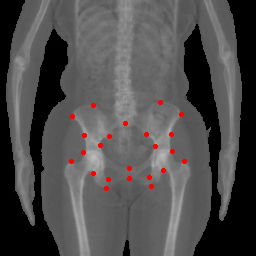

In [20]:
show_kps("00579_82")

In [101]:
with open(os.path.join(anno_path, "anno_23kps.json"), 'w') as f:
    json.dump(anno_23kps, f)

#### For head

In [58]:
!pwd

/Users/alexxu/Library/CloudStorage/Box-Box/Narasimhan_lab/hip_shape


In [64]:
dtypes = {"Image ID": object}
df_82 = pd.read_csv(anno_path + '816_288_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
df_93 = pd.read_csv(anno_path + '960_384_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
mapping_82 = df_82[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()
mapping_93 = df_93[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()

In [59]:
train_82 = json.load(open("../left_vs_right/annotation_data/person_keypoints_smaller_images_train.json"))
val_82 = json.load(open("../left_vs_right/annotation_data/person_keypoints_smaller_images_val.json"))
train_93 = json.load(open("../left_vs_right/annotation_data/person_keypoints_larger_images_train.json"))
val_93 = json.load(open("../left_vs_right/annotation_data/person_keypoints_larger_images_val.json"))

In [97]:
anno_path = "annotation_images/"

In [102]:
# combine train and val
tmp_dict_82 = {}
tmp_dict_93 = {}
tmp_dict_82['annotations'] = train_82['annotations'] + val_82['annotations']
tmp_dict_93['annotations'] = train_93['annotations'] + val_93['annotations']

# reformat
dict_82 = {}
dict_93 = {}

for i in range(len(tmp_dict_82['annotations'])):
    kps = np.array(tmp_dict_82['annotations'][i]['keypoints']).reshape(-1,3)[:5,:2]
    kps[:, 0] = kps[:, 0] - 16
    dict_82["{:05d}".format(tmp_dict_82['annotations'][i]['image_id']) + "_82"] = kps.tolist()

for i in range(len(tmp_dict_93['annotations'])):
    kps = np.array(tmp_dict_93['annotations'][i]['keypoints']).reshape(-1,3)[:5,:2]
    kps[:, 0] = kps[:, 0] - 64
    dict_93["{:05d}".format(tmp_dict_93['annotations'][i]['image_id']) + "_93"] = kps.tolist()

# combine
tv_all = {**dict_82, **dict_93}

# save
with open(os.path.join(anno_path, "tv_both_head.json"), 'w') as f:
    json.dump(tv_all, f)

In [121]:
img_path_82 = "../UKB_xray_image_info/jpg/816_288/"
img_path_93 = "../UKB_xray_image_info/jpg/960_384/"

def show_kps(image_id):
    if image_id[-2:] == "82":
        img_path = img_path_82
        iid = [k for k, v in mapping_82.items() if v == image_id[:-3]][0]
        kps = dict_82[image_id]
    else:
        img_path = img_path_93
        iid = [k for k, v in mapping_93.items() if v == image_id[:-3]][0]
        kps = dict_93[image_id]

    img = Image.open(os.path.join(img_path, iid))

    img = img.convert('RGB')
    draw = ImageDraw.Draw(img)
    
    # for kp in kps:
    #     draw.ellipse((kp[0]-2, kp[1]-2, kp[0]+2, kp[1]+2), fill = 'red')
    kp = kps[3]
    draw.ellipse((kp[0]-2 + 64, kp[1]-2, kp[0]+2 + 64, kp[1]+2), fill = 'red')
    kp = kps[4]
    draw.ellipse((kp[0]-2 + 64, kp[1]-2, kp[0]+2 + 64, kp[1]+2), fill = 'red')
    return img
    

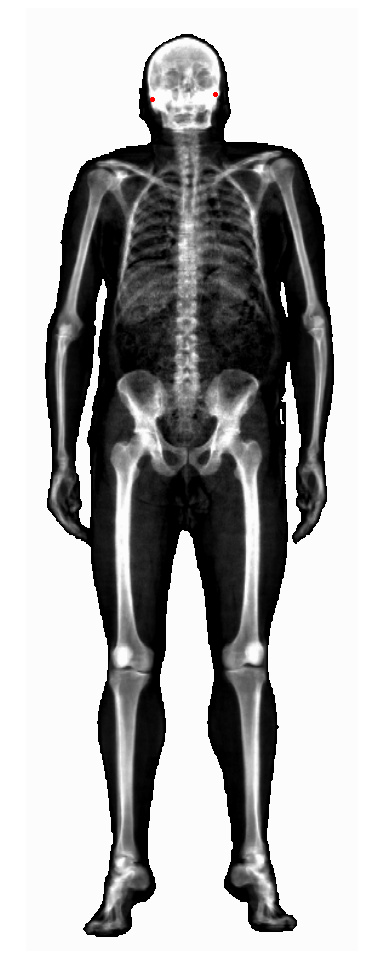

In [122]:
show_kps("04284_93")

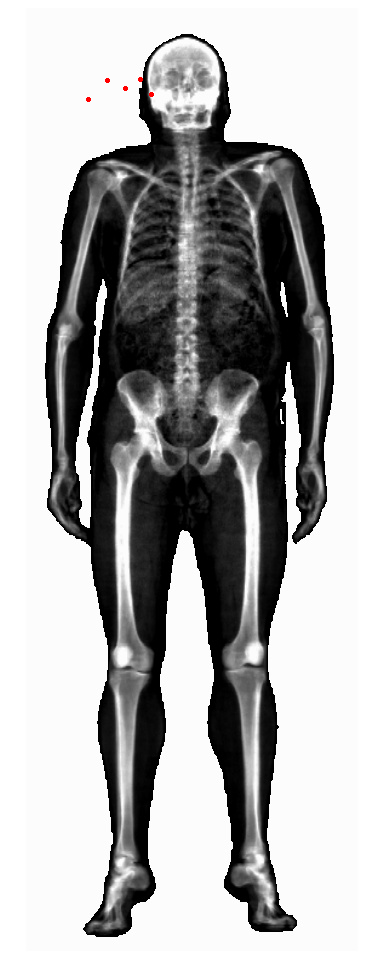

In [120]:
show_kps("04284_93")